In [1]:
import os, re, glob
import numpy as np
import pandas as pd
import cv2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt


BROWN_LOWER = np.array([154, 139, 107], dtype=np.uint8)
BROWN_UPPER = np.array([162, 184, 200], dtype=np.uint8)

NUC_BLUE_LOWER = np.array([100,  50,  30], dtype=np.uint8)
NUC_BLUE_UPPER = np.array([150, 255, 230], dtype=np.uint8)

OPEN_K, CLOSE_K = 3, 5             
EDGE_LOW_HIGH = (30, 100)          
DILATE_R_EOI, DILATE_R_BPI = 2, 3   

def to_hsv(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

def imread_rgb(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def detect_brown_mask(img_rgb,
                      lower=BROWN_LOWER, upper=BROWN_UPPER,
                      open_k=OPEN_K, close_k=CLOSE_K):
    hsv = to_hsv(img_rgb)
    mask = cv2.inRange(hsv, lower, upper)
    if open_k>1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
    if close_k>1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)
    return mask  # uint8 {0,255}

def detect_blue_mask(img_rgb,
                     lower=NUC_BLUE_LOWER, upper=NUC_BLUE_UPPER):
    hsv = to_hsv(img_rgb)
    return cv2.inRange(hsv, lower, upper)

def canny_edges_v(img_rgb, low=EDGE_LOW_HIGH[0], high=EDGE_LOW_HIGH[1]):
    v = to_hsv(img_rgb)[...,2]
    return cv2.Canny(v, low, high)

def connected_component_sizes(mask):
    lbl, n = ndi.label(mask>0)
    if n == 0:
        return np.array([], dtype=np.int32)
    sizes = np.bincount(lbl.ravel())
    return sizes[1:]  # 去背景

def laplacian_energy(gray):
    lap = cv2.Laplacian(gray, cv2.CV_32F, ksize=3)
    return float(np.mean(np.abs(lap)))

def compute_tile_metrics(tile_rgb):
    """
    Returns five sub-metrics for this tile + a summary score (HASS):
    
    SAF — Artifact area fraction
    
    P95_norm — 95th percentile of connected domain area / 200 (normalized)
    
    EOI — Artifact neighborhood ∩ edge pixels / total number of edge pixels
    
    BPI — Artifact neighborhood ∩ blue-violet pixels / total number of blue-violet pixels
    
    TDI — Laplacian energy drop between nearby and distant artifacts (0-1)
    
    HASS — Weighted summary of the above (emphasizing geometry/kernel correlation)
    """
    H,W,_ = tile_rgb.shape
    area = H*W

   
    M = detect_brown_mask(tile_rgb)
    saf = float((M>0).sum()) / area

   
    sizes = connected_component_sizes(M)
    p95 = float(np.percentile(sizes, 95)) if sizes.size>0 else 0.0
    p95_norm = min(1.0, p95 / 200.0)  # 以半径≈8px 的圆面积≈200 作为参考

   
    E = canny_edges_v(tile_rgb)
    E_cnt = int((E>0).sum())
    M_e = cv2.dilate(M, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2*DILATE_R_EOI+1,2*DILATE_R_EOI+1)))
    eoi = float(((E>0) & (M_e>0)).sum()) / max(1, E_cnt)

   
    B = detect_blue_mask(tile_rgb)
    B_cnt = int((B>0).sum())
    M_b = cv2.dilate(M, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2*DILATE_R_BPI+1,2*DILATE_R_BPI+1)))
    bpi = float(((B>0) & (M_b>0)).sum()) / max(1, B_cnt)

   
    hsv = to_hsv(tile_rgb)
    gray = hsv[...,2]
    near = (cv2.dilate(M, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))>0)
    far  = (cv2.erode((M==0).astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))>0)
    if near.any() and far.any():
        e_near = laplacian_energy(gray[near])
        e_far  = laplacian_energy(gray[far])
        tdi = max(0.0, 1.0 - (e_near / (e_far + 1e-6)))
        tdi = min(1.0, tdi)
    else:
        tdi = 0.0

   
    w_saf, w_p95, w_eoi, w_bpi, w_tdi = 0.25, 0.15, 0.30, 0.20, 0.10
    hass = (w_saf*saf) + (w_p95*p95_norm) + (w_eoi*eoi) + (w_bpi*bpi) + (w_tdi*tdi)

    return {"SAF": saf, "P95_norm": p95_norm, "EOI": eoi, "BPI": bpi, "TDI": tdi, "HASS": hass}

def filename_to_rc(fn):
    """
    Parse (row, col) from 'tile_r00_c01_id01.png'; adjust the regular expression if naming is different.
    """
    m = re.search(r"_r(\d+)_c(\d+)_", fn)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

In [2]:
tile_dir = "./tiles/img0"
out_dir  = "./meta/noise_quant/img0"
os.makedirs(out_dir, exist_ok=True)


paths = glob.glob(os.path.join(tile_dir, "tile_*.png"))
def rc_key(p):
    r,c = filename_to_rc(os.path.basename(p))
    return (r if r is not None else 0, c if c is not None else 0)
paths = sorted(paths, key=rc_key)

print(f"Found {len(paths)} tiles")
rows = []
for p in paths:
    img = imread_rgb(p)
    met = compute_tile_metrics(img)
    r,c = filename_to_rc(os.path.basename(p))
    rows.append({
        "filename": os.path.basename(p),
        "row": r, "col": c,
        **met
    })

df = pd.DataFrame(rows)


qs = np.percentile(df["HASS"].values, [20,40,60,80])
def to_level(v):
    return 1 + (v>qs[0]) + (v>qs[1]) + (v>qs[2]) + (v>qs[3])
df["noise_level_5bin"] = df["HASS"].apply(to_level)


fixed_thr = [0.05, 0.10, 0.15, 0.25]
def to_level_fixed(v, thr=fixed_thr):
    lvl = 1
    for t in thr:
        if v > t: lvl += 1
    return min(lvl, 5)
df["noise_level_fixed5"] = df["HASS"].apply(to_level_fixed)

display(df.head())

Found 36 tiles


,filename,row,col,SAF,P95_norm,EOI,BPI,TDI,HASS,noise_level_5bin,noise_level_fixed5
0,tile_r00_c00_id00.png,0,0,0.054644,0.795,0.234773,0.019433,0.0,0.207230,3,4
1,tile_r00_c01_id01.png,0,1,0.019628,0.369,0.114317,0.020862,0.0,0.098724,1,2
2,tile_r00_c02_id02.png,0,2,0.043588,0.760,0.198085,0.004698,0.0,0.185262,2,4
3,tile_r00_c03_id03.png,0,3,0.217956,1.000,0.481787,0.022010,0.0,0.353427,4,5
4,tile_r00_c04_id04.png,0,4,0.257832,1.000,0.571682,0.058960,0.0,0.397755,5,5


In [4]:
csv_path = os.path.join(out_dir, "tiles_noise_metrics.csv")
df.to_csv(csv_path, index=False)
print(f"[OK] saved -> {csv_path}")

[OK] saved -> /vol/projects/yxi24/SegDecon/REVERSE/meta/noise_quant/img0/tiles_noise_metrics.csv


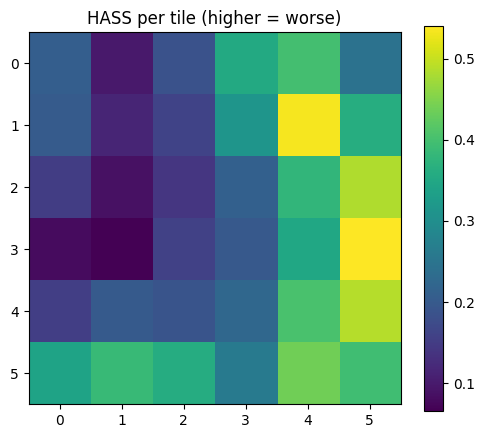

In [3]:
grid = (6,6)
HASS_mat = np.zeros(grid, dtype=np.float32)
for _, r in df.iterrows():
    if r["row"] is not None and r["col"] is not None:
        HASS_mat[int(r["row"]), int(r["col"])] = r["HASS"]

plt.figure(figsize=(6,5))
plt.imshow(HASS_mat, interpolation="nearest")
plt.title("HASS per tile (higher = worse)")
plt.colorbar()
plt.xticks(range(grid[1])); plt.yticks(range(grid[0]))
plt.show()

[OK] 合并总表已保存 -> /vol/projects/yxi24/SegDecon/REVERSE/meta/noise_quant/img0/img0_merged_noise_results.csv


,filename,count_gt,pred_sd,abs_err_sd,ape_sd,pred_sg,abs_err_sg,ape_sg,row,col,SAF,P95_norm,EOI,BPI,TDI,HASS,noise_level_5bin,noise_level_fixed5,d_abs_err,d_ape
0,tile_r00_c00_id00.png,46,197,151,3.282609,46,0,0.000000,0,0,0.054644,0.795,0.234773,0.019433,0.0,0.207230,3,4,151,3.282609
1,tile_r00_c01_id01.png,43,180,137,3.186047,39,4,0.093023,0,1,0.019628,0.369,0.114317,0.020862,0.0,0.098724,1,2,133,3.093023
2,tile_r00_c02_id02.png,48,260,212,4.416667,44,4,0.083333,0,2,0.043588,0.760,0.198085,0.004698,0.0,0.185262,2,4,208,4.333333
3,tile_r00_c03_id03.png,38,305,267,7.026316,53,15,0.394737,0,3,0.217956,1.000,0.481787,0.022010,0.0,0.353427,4,5,252,6.631579
4,tile_r00_c04_id04.png,30,310,280,9.333333,37,7,0.233333,0,4,0.257832,1.000,0.571682,0.058960,0.0,0.397755,5,5,273,9.100000


按 5 档（分位）汇总：


,noise_level_5bin,n,med_dAPE,q25_dAPE,q75_dAPE,med_dAbs
0,1,8,3.512247,2.999255,4.061804,125.0
1,2,7,8.151515,6.309677,9.381536,269.0
2,3,7,6.812500,6.091328,8.771711,242.0
3,4,7,9.812500,5.826659,12.566409,314.0
4,5,7,4.425000,3.680680,10.171212,177.0


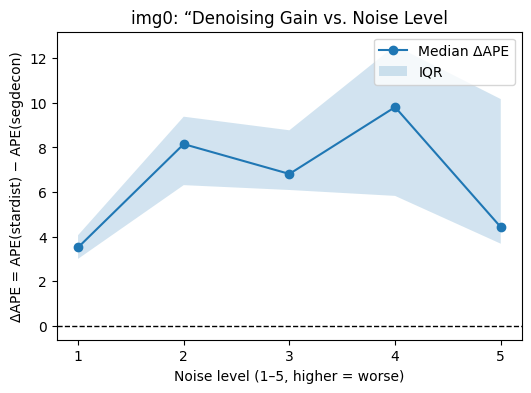

建议阈值：当噪声等级 ≥ 2 时**必须启用去噪**。
  证据：ΔAPE 中位差 = 4.164（高≥2 vs 低<2），Mann–Whitney U p=0.0017；样本量 高组=28、低组=8。
工程可选阈值：等级 ≥ 1 时，ΔAPE 的中位数 > 0.10。


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu


slide = "img0"


base_meta = "/vol/projects/yxi24/SegDecon/REVERSE/meta"


noise_metrics_csv = f"{base_meta}/noise_quant/{slide}/tiles_noise_metrics.csv"

# 2)  StarDist 
csv_stardist = f"{base_meta}/result_stardist/{slide}/{slide}_counts_compare_stardist.csv"

# 3) SegDecon
csv_seagdecon = f"{base_meta}/result_segdecon/{slide}/{slide}_counts_compare_segdecon.csv"

# ---------- read----------
met = pd.read_csv(noise_metrics_csv)  # 包含 HASS, noise_level_5bin 等
sd  = pd.read_csv(csv_stardist)       # cols: tile_id, filename, count_gt, pred_count, err(=pred-gt)
sg  = pd.read_csv(csv_seagdecon)


def prep(df, tag):
    out = df.copy()
    if "pred" not in out.columns and "pred_count" in out.columns:
        out.rename(columns={"pred_count":"pred"}, inplace=True)
    # 绝对误差与相对百分比误差（APE）
    out[f"abs_err_{tag}"] = (out["pred"] - out["count_gt"]).abs()
    out[f"ape_{tag}"]     = out[f"abs_err_{tag}"] / out["count_gt"].clip(lower=1)
    return out[["filename","count_gt","pred",f"abs_err_{tag}",f"ape_{tag}"]]

sd_ = prep(sd, "sd")   # StarDist
sg_ = prep(sg, "sg")   # SegDecon（


res = pd.merge(sd_, sg_, on=["filename","count_gt"], how="inner", suffixes=("_sd","_sg"))
if res.empty:
    raise RuntimeError("..")


df = pd.merge(res, met, on="filename", how="inner")
if df.empty:
    raise RuntimeError("..")


df["d_abs_err"] = df["abs_err_sd"] - df["abs_err_sg"]
df["d_ape"]     = df["ape_sd"]     - df["ape_sg"]


out_dir = os.path.dirname(noise_metrics_csv)
out_merged = os.path.join(out_dir, f"{slide}_merged_noise_results.csv")
df.to_csv(out_merged, index=False)
print(f"[OK] save -> {out_merged}")
display(df.head())


summ = df.groupby("noise_level_5bin").agg(
    n=("filename","count"),
    med_dAPE=("d_ape","median"),
    q25_dAPE=("d_ape", lambda x: np.percentile(x,25)),
    q75_dAPE=("d_ape", lambda x: np.percentile(x,75)),
    med_dAbs=("d_abs_err","median"),
).reset_index().sort_values("noise_level_5bin")

print("按 5 档（分位）汇总：")
display(summ)


levels = summ["noise_level_5bin"].values
med = summ["med_dAPE"].values
q25 = summ["q25_dAPE"].values
q75 = summ["q75_dAPE"].values

plt.figure(figsize=(6,4))
plt.plot(levels, med, marker="o", label="Median ΔAPE")
plt.fill_between(levels, q25, q75, alpha=0.2, label="IQR")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Noise level (1–5, higher = worse)")
plt.ylabel("ΔAPE = APE(stardist) − APE(segdecon)")
plt.title(f"{slide}: “Denoising Gain vs. Noise Level")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()


candidates = [2,3,4]
best = None
for L in candidates:
    high = df[df["noise_level_5bin"] >= L]["d_ape"].values
    low  = df[df["noise_level_5bin"] <  L]["d_ape"].values
    if len(high) < 5 or len(low) < 5:
        continue
    stat, p = mannwhitneyu(high, low, alternative="two-sided")
    diff_med = float(np.median(high) - np.median(low))
    score = diff_med if p < 0.05 else -np.inf
    if (best is None) or (score > best["score"]):
        best = {"L": L, "p": p, "diff_med": diff_med,
                "n_high": int(len(high)), "n_low": int(len(low)), "score": score}

if best is None:
    print("p≥0.05")
else:
    print(f"建议阈值：当噪声等级 ≥ {best['L']} 时**必须启用去噪**。")
    print(f"  证据：ΔAPE 中位差 = {best['diff_med']:.3f}（高≥{best['L']} vs 低<{best['L']}），"
          f"Mann–Whitney U p={best['p']:.4f}；样本量 高组={best['n_high']}、低组={best['n_low']}。")


thr_engineering = None
for L in [1,2,3,4,5]:
    high = df[df["noise_level_5bin"] >= L]["d_ape"].values
    if len(high) >= 5 and np.median(high) > 0.10:   # 10 个百分点，你可改成 0.05/0.15
        thr_engineering = L
        break
if thr_engineering is not None:
    print(f"工程可选阈值：等级 ≥ {thr_engineering} 时，ΔAPE 的中位数 > 0.10。")

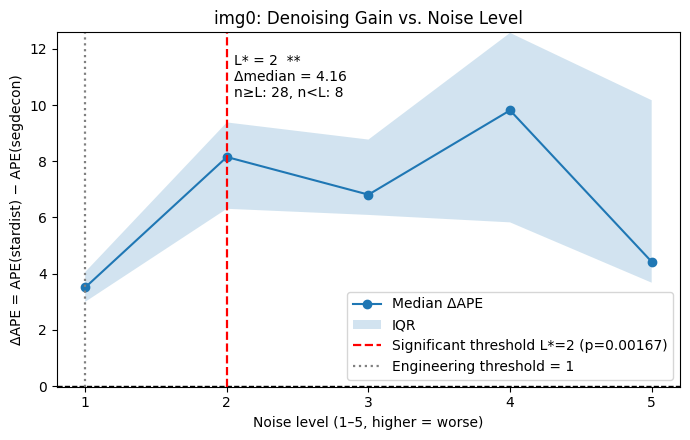

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

LEVEL_COL = "noise_level_5bin"


if 'best' not in globals() or best is None:
    candidates = [2,3,4]
    best = None
    for L in candidates:
        high = df[df[LEVEL_COL] >= L]["d_ape"].values
        low  = df[df[LEVEL_COL] <  L]["d_ape"].values
        if len(high) < 5 or len(low) < 5:
            continue
        stat, p = mannwhitneyu(high, low, alternative="two-sided")
        diff_med = float(np.median(high) - np.median(low))
        score = diff_med if p < 0.05 else -np.inf
        if (best is None) or (score > best["score"]):
            best = {"L": L, "p": p, "diff_med": diff_med,
                    "n_high": int(len(high)), "n_low": int(len(low)), "score": score}

if 'thr_engineering' not in globals() or thr_engineering is None:
    thr_engineering = None
    for L in [1,2,3,4,5]:
        high = df[df[LEVEL_COL] >= L]["d_ape"].values
        if len(high) >= 5 and np.median(high) > 0.10: 
            thr_engineering = L
            break


levels = summ[LEVEL_COL].values
med = summ["med_dAPE"].values
q25 = summ["q25_dAPE"].values
q75 = summ["q75_dAPE"].values

def p_to_stars(p):
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < 0.05 else 'ns'


ymin = min(0.0, float(np.nanmin(q25)), float(np.nanmin(med))) - 0.02
ymax = max(float(np.nanmax(q75)), float(np.nanmax(med))) + 0.02
yspan = ymax - ymin

plt.figure(figsize=(7,4.5))
plt.plot(levels, med, marker="o", label="Median ΔAPE")
plt.fill_between(levels, q25, q75, alpha=0.2, label="IQR")
plt.axhline(0, color="black", linestyle="--", linewidth=1)


if best is not None:
    L = best["L"]; p = best["p"]; diff = best["diff_med"]
    stars = p_to_stars(p)
    plt.axvline(L, color="red", linestyle="--", linewidth=1.6,
                label=f"Significant threshold L*={L} (p={p:.3g})")
   
    plt.text(L + 0.05, ymax - 0.06*yspan,
             f"L* = {L}  {stars}\nΔmedian = {diff:.2f}\n"
             f"n≥L: {best['n_high']}, n<L: {best['n_low']}",
             va="top")


if (thr_engineering is not None) and (best is None or thr_engineering != best["L"]):
    plt.axvline(thr_engineering, color="gray", linestyle=":", linewidth=1.6,
                label=f"Engineering threshold = {thr_engineering}")

plt.ylim(ymin, ymax)
plt.xticks([1,2,3,4,5])
plt.xlabel("Noise level (1–5, higher = worse)")
plt.ylabel("ΔAPE = APE(stardist) − APE(segdecon)")
plt.title(f"{slide}: Denoising Gain vs. Noise Level")
plt.legend()
plt.tight_layout()
plt.show()